In [1]:
from game import Move, Player, Game
from quixo import Quixo
from symmetry import SymmetryGenerator
from main import RandomPlayer, MyPlayer
from reinforcement_learning import MonteCarloPlayer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

C:\Users\bea-c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check Symmetry Functionalities

In [2]:
# Example usage:
board = np.ones((5, 5), dtype=np.uint8) * -1
board[2, 1] = 0
board[1, 1] = 1
symmetry_generator = SymmetryGenerator()
all_symmetries = symmetry_generator.board_get_symmetries(board)

# Print all symmetries as full boards
print("All Symmetries:")
for label, state in all_symmetries:
    print(f"Transformation: {label}")
    print(state)

# Find the lexicographically minimum state and its transformation label
print("\n\nLexicographically minimum state:")
transf_performed, base_state = symmetry_generator.get_base_state(board)
print(f"Transformation: {transf_performed}")
print(base_state)

# Action
from_pos = (2, 3)
slide = Move.TOP

# Get the action in the lexicographically minimum state
print("\n\nAction in lexicographically minimum state:")
base_from_pos, base_slide = symmetry_generator.get_base_action(from_pos, slide, transf_performed)
print(f"From position: {base_from_pos}")
print(f"Slide: {base_slide}")

# Retrieve the original action
print("\n\nOriginal action:")
original_from_pos, original_slide = symmetry_generator.get_original_action(base_from_pos, base_slide, transf_performed)
print(f"From position: {original_from_pos}")
print(f"Slide: {original_slide}")

All Symmetries:
Transformation: identity
[[-1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: rotate_90
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1  1  0 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: rotate_180
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1  0 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: rotate_270
[[-1 -1 -1 -1 -1]
 [-1 -1  0  1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: reflect_horizontal
[[-1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  0 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: reflect_vertical
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: reflect_diagonal
[[-1 -1 -1 -1 -1]
 [-1  1  0 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Transformation: reflect_antidiagonal
[[-1 -1 -1 -1 -1]
 [-1 -1  0  1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]


Lexicograph

### Example match
In this example, we'll show the phases of a game of Quixo between two random players. We're using our extended class `Quixo(Game)` which allows us to have more control over the visualization of each game state.

This is done in order to verify that the extensions that we have applied are working as expected.

In [3]:
g = Quixo()
player1 = RandomPlayer()
player2 = RandomPlayer()
winner = g.play(player1, player2, verbose=True, debug=True)
print(f"Winner: Player {winner}")


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Number of possible actions: 44
Possible actions:  [((0, 0), <Move.BOTTOM: 1>), ((0, 4), <Move.TOP: 0>), ((0, 0), <Move.RIGHT: 3>), ((4, 0), <Move.LEFT: 2>), ((1, 0), <Move.BOTTOM: 1>), ((1, 0), <Move.LEFT: 2>), ((1, 0), <Move.RIGHT: 3>), ((1, 4), <Move.TOP: 0>), ((1, 4), <Move.LEFT: 2>), ((1, 4), <Move.RIGHT: 3>), ((0, 1), <Move.RIGHT: 3>), ((0, 1), <Move.TOP: 0>), ((0, 1), <Move.BOTTOM: 1>), ((4, 1), <Move.LEFT: 2>), ((4, 1), <Move.TOP: 0>), ((4, 1), <Move.BOTTOM: 1>), ((2, 0), <Move.BOTTOM: 1>), ((2, 0), <Move.LEFT: 2>), ((2, 0), <Move.RIGHT: 3>), ((2, 4), <Move.TOP: 0>), ((2, 4), <Move.LEFT: 2>), ((2, 4), <Move.RIGHT: 3>), ((0, 2), <Move.RIGHT: 3>), ((0, 2), <Move.TOP: 0>), ((0, 2), <Move.BOTTOM: 1>), ((4, 2), <Move.LEFT: 2>), ((4, 2), <Move.TOP: 0>), ((4, 2), <Move.BOTTOM: 1>), ((3, 0), <Move.BOTTOM: 1>), ((3, 0), <Move.LEFT: 2>), ((3, 0), <Move.RIGHT: 3>), ((3, 4), <Move.TOP: 0>), ((3, 4),

In [4]:
def collect_results(player1, player2, n_games=100):
    
    # 1. Initialize the results
    results = defaultdict(int)

    # 2. Play the games
    for _ in tqdm(range(n_games)):
        g = Quixo()
        winner = g.play(player1, player2, verbose=False, debug=False)
        results[winner] += 1
        
    return results

## Training process Monte Carlo Player

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


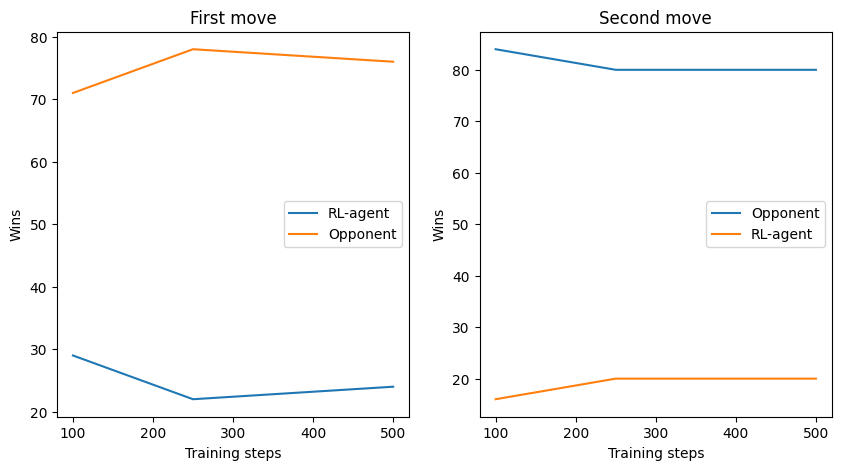

In [5]:
g = Quixo()
mc_player = MonteCarloPlayer()
opponent = RandomPlayer()

training_steps = [100, 250, 500]
training_results_move_first = []
training_results_move_second = []

previous_steps = 0

for steps in tqdm(training_steps):
    
    # 1. Train the RL-agent against the opponent for a given number of steps
    mc_player.train(steps - previous_steps)
    previous_steps = steps

    # 2. EVAL: Play 100 games against the opponent making the first move
    results = collect_results(mc_player, opponent, n_games=100)
    training_results_move_first.append(results)

    # 3. EVAL: Play 100 games against the opponent making the second move
    results = collect_results(opponent, mc_player, n_games=100)
    training_results_move_second.append(results)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("First move")
plt.xlabel("Training steps")
plt.ylabel("Wins")
plt.plot(training_steps, [r[0] for r in training_results_move_first], label="RL-agent")
plt.plot(training_steps, [r[1] for r in training_results_move_first], label="Opponent")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Second move")
plt.xlabel("Training steps")
plt.ylabel("Wins")
plt.plot(training_steps, [r[0] for r in training_results_move_second], label="Opponent")
plt.plot(training_steps, [r[1] for r in training_results_move_second], label="RL-agent")
plt.legend()

plt.show()

In [6]:
g = Quixo()
g.play(mc_player, opponent, verbose=True, debug=True)


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Number of possible actions: 44
Possible actions:  [((0, 0), <Move.BOTTOM: 1>), ((0, 4), <Move.TOP: 0>), ((0, 0), <Move.RIGHT: 3>), ((4, 0), <Move.LEFT: 2>), ((1, 0), <Move.BOTTOM: 1>), ((1, 0), <Move.LEFT: 2>), ((1, 0), <Move.RIGHT: 3>), ((1, 4), <Move.TOP: 0>), ((1, 4), <Move.LEFT: 2>), ((1, 4), <Move.RIGHT: 3>), ((0, 1), <Move.RIGHT: 3>), ((0, 1), <Move.TOP: 0>), ((0, 1), <Move.BOTTOM: 1>), ((4, 1), <Move.LEFT: 2>), ((4, 1), <Move.TOP: 0>), ((4, 1), <Move.BOTTOM: 1>), ((2, 0), <Move.BOTTOM: 1>), ((2, 0), <Move.LEFT: 2>), ((2, 0), <Move.RIGHT: 3>), ((2, 4), <Move.TOP: 0>), ((2, 4), <Move.LEFT: 2>), ((2, 4), <Move.RIGHT: 3>), ((0, 2), <Move.RIGHT: 3>), ((0, 2), <Move.TOP: 0>), ((0, 2), <Move.BOTTOM: 1>), ((4, 2), <Move.LEFT: 2>), ((4, 2), <Move.TOP: 0>), ((4, 2), <Move.BOTTOM: 1>), ((3, 0), <Move.BOTTOM: 1>), ((3, 0), <Move.LEFT: 2>), ((3, 0), <Move.RIGHT: 3>), ((3, 4), <Move.TOP: 0>), ((3, 4),

1

In [7]:
# print q-table length
print(len(mc_player.q_table))

# print the entries of the q-table
sorted_q_table = sorted(mc_player.q_table.items(), key=lambda x: x[1], reverse=True)
for i in range(len(sorted_q_table)):
    print(sorted_q_table[i])

10261
(('[[ 0  0  0  0  1]\n [ 1 -1  0  1  1]\n [ 1  1 -1 -1  1]\n [ 0  0 -1 -1  1]\n [ 1  1  0  0  0]]', ((4, 4), <Move.BOTTOM: 1>)), 2.349)
(('[[ 0  0  1  0  1]\n [ 1  0 -1 -1  1]\n [ 0 -1 -1 -1 -1]\n [ 0 -1 -1 -1 -1]\n [ 1 -1  0 -1  1]]', ((4, 4), <Move.LEFT: 2>)), 2.04849)
(('[[ 0  0  0  0 -1]\n [ 1 -1 -1 -1 -1]\n [ 1 -1 -1 -1  0]\n [ 1 -1 -1 -1  0]\n [ 1 -1 -1 -1  1]]', ((0, 2), <Move.TOP: 0>)), 2.0)
(('[[ 0  0  0  0  1]\n [ 1  1  0 -1 -1]\n [ 0  0 -1 -1  1]\n [ 1 -1 -1 -1 -1]\n [ 1  1 -1  1  1]]', ((0, 3), <Move.TOP: 0>)), 2.0)
(('[[ 1  0  0  1  1]\n [ 0  0  0  0 -1]\n [ 1  0 -1  0  1]\n [ 0 -1  1 -1  1]\n [ 1  0  1  1  1]]', ((0, 3), <Move.RIGHT: 3>)), 2.0)
(('[[ 1  0  0  1  1]\n [ 0  0  0  0 -1]\n [ 1 -1 -1 -1  0]\n [ 1 -1 -1 -1  1]\n [-1  1 -1 -1  1]]', ((0, 3), <Move.RIGHT: 3>)), 2.0)
(('[[ 0  1  0  1  1]\n [ 1  0 -1 -1 -1]\n [ 1  0 -1 -1  0]\n [ 1  0  1 -1  0]\n [ 1  0  0 -1  1]]', ((4, 4), <Move.BOTTOM: 1>)), 2.0)
(('[[ 1  0 -1  0  1]\n [ 0 -1 -1  0  1]\n [-1 -1 -1  0  0]\n

In [8]:
episodes = 2

# 0. Initialize the symmetry generator
SG = SymmetryGenerator()

# 1. Define the players
mc_player = MonteCarloPlayer()
mc_player_id = 0
random_player = RandomPlayer()
players = (mc_player, random_player)

# 2. Play the given number of episodes (games)
for _ in tqdm(range(episodes)):

    # 2.1. Initialize the game
    game = Quixo()
    winner = -1

    # 2.2. Initialize the episode
    reward_counter = 0    # Total reward of the episode
    trajectory = []       # List of (state, action, reward) tuples representing the steps of the episode
    players = (players[1], players[0])      # Switch the players
    mc_player_id = 1 - mc_player_id         # Switch the player ID

    # 2.3. Play the episode
    while winner < 0:

        # 2.3.0. Get the current player
        game.change_player()
        current_player = players[game.get_current_player()]

        game.print()

        # 2.3.1. Act according to the current player
        if current_player == mc_player: # Monte Carlo player

            # Get the base state of the current board
            transf_label, base_state = mc_player._get_base_state(game)
            
            # Get the action to perform and the base action to save in the Q-table
            from_pos, slide = current_player._get_action(game, training_phase=True)
            base_action = SG.get_base_action(from_pos, slide, transf_label)

            # Get the reward of the action
            reward = current_player._get_action_reward(game, (from_pos, slide))
            reward_counter += reward

            # Make the move
            game.make_move(from_pos, slide)

            print(f"Real action: {from_pos} {slide}")
            print(f"Base state:\n{base_state}")
            print(f"Tansformation: {transf_label}")
            print(f"Base action: {base_action}")

            # Store the base state-action-reward in the trajectory
            trajectory.append((base_state, base_action, reward))

        else: # Random player
           
            ok = False
            while not ok:

                # Get the action to perform
                from_pos, slide = current_player.make_move(game)

                # Make the move and check if it was successful
                ok = game.make_move(from_pos, slide)

        # 2.3.2. Check if there is a winner
        winner = game.check_winner()
        if winner >= 0:
            
            # Get the final reward
            end_reward = mc_player._get_end_reward(mc_player_id, winner)
            reward_counter += end_reward - reward # Discount the last partial reward

            # Update the last state-action pair in the trajectory with the final reward
            trajectory[-1] = (trajectory[-1][0], trajectory[-1][1], end_reward)

    # ..EPISODE ENDS..............................................  

    # 2.4. Update the Q-table
    mc_player._update_q_table(trajectory)

    # 2.5. Update the exploration rate
    mc_player.epsilon = max(mc_player.e_min, mc_player.epsilon * mc_player.e_decay)

100%|██████████| 2/2 [00:00<00:00, 15.68it/s]


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ❌ 

Current player: 🔘
Real action: (0, 0) Move.BOTTOM
Base state:
[[ 1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Tansformation: rotate_180
Base action: ((4, 4), <Move.TOP: 0>)

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
🔘 ⬜ ⬜ ⬜ ❌ 

Current player: ❌

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ❌ 
🔘 ⬜ ⬜ ⬜ ❌ 

Current player: 🔘
Real action: (0, 0) Move.BOTTOM
Base state:
[[ 0 -1 -1 -1  1]
 [-1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
Tansformation: reflect_vertical
Base action: ((4, 0), <Move.TOP: 0>)

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
🔘 ⬜ ⬜ ⬜ ❌ 
🔘 ⬜ ⬜ ⬜ ❌ 

Current player: ❌

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
🔘 ⬜ ⬜ ⬜ ❌ 
❌ 🔘 ⬜ ⬜ ❌ 

Current player: 🔘
Real action: (0, 0) Move.BOTTOM
Base sta